# Project Overview

### Background:
The objective of the project is to find a good spot for a new sushi restaurant in Stuttgart, Germany.



<table><tr><td><img src='Stuttgart-Innenstadt.jpg' width= "600"></td><td><img src='maki-sushi.jpg'width= "255"></td></tr></table>

### Approach / Methodology:
To achieve this, the DBSCAN Clustering Algorithm will be used. This algorithms can find the number of clusters depending on a spatial radius, making it a good fit for the given problem. \
These clusters will be used to create a map, that is visualizing hot spots, which likely are too competitive to create a new business. The solution will be to pick a spot, that is close to the center, but only part of a small cluster or even only consisting of a maximum of three outliers.

Additionally, there will also be an attractivity score calculated for each cluster respectively. This will be depending on the most popular leasure time spots inside or very close to the cluster compared to the number of restaurants.

### Data:
The used data will be explorational data from the Foursquare DB, which is accessable without authentification. The core of the data are the geographical coordinates in order to create the map and trend.


In [2]:
import pandas as pd
import requests
from pandas.io.json import json_normalize

In [3]:
client_id = "XTLZ3AQ5BOUXV0TCYNUE5OU1M4TASGEEDDEQ1MHTFBFVBNZX"
client_secret = "WVM4G5KLGA3DZ50Q1UASWFYKNO20NRLKJEZAFFDEF3HHP0CO"

latitude = 50.938056
longitude = 6.956944
radius = 4000


In [4]:
def get_data(date, search_query): 
    '''
    This function returns a dataframe of the Foursquare Data depending on the given date and search term
    '''
    
    url = ('https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'
            .format(client_id, client_secret, latitude, longitude, date, search_query, radius, 500))


    results = requests.get(url).json()
    venues = results['response']['venues']

    df = pd.json_normalize(venues)

    return df

In [5]:
# Get sushi restaurant data
main_data = get_data(20200514, "sushi").loc[:,["name", "location.lat", "location.lng"]]


In [6]:
#Get leasure data by explore statement

url = ('https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query=Fun&radius={}&limit={}'
            .format(client_id, client_secret, latitude, longitude, 20200514, radius, 500))

results = requests.get(url).json()
venues = results['response']


leisure = venues["groups"][0]["items"]

result = [entry["venue"] for entry in leisure]

result = [(entry["location"]["lat"], entry["location"]["lng"]) for entry in result]
leisure = pd.DataFrame(result, columns= ["lat", "lng"])
leisure

,lat,lng
0,50.938530,6.954084
1,50.937882,6.962241
2,50.940537,6.960486
3,50.938243,6.962875
4,50.937425,6.958523
...,...,...
95,50.922367,6.965660
96,50.948068,6.908591
97,50.916994,6.928838
98,50.961884,6.978495


In [7]:
"Number of Sushi Restaurants in Stuttgart: {}".format(main_data.shape[0])

'Number of Sushi Restaurants in Stuttgart: 48'

### Clustering

In [8]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [9]:
coords = main_data.loc[:,["location.lat", "location.lng"]]
coords = StandardScaler().fit_transform(coords)

db_cluster = DBSCAN(eps = 0.35, min_samples = 3).fit(coords)

labels = db_cluster.labels_
label_num = len(np.unique(labels))
main_data["label"] = labels


In [99]:
label_counter = {}

for lat, lng in leisure.values:
    sushi_coords = main_data.loc[:,["location.lat", "location.lng"]]
    sushi_coords.iloc[:,0] = sushi_coords.iloc[:,0] - lat
    sushi_coords.iloc[:,1] = sushi_coords.iloc[:,1] - lng
    sushi_coords = np.abs(np.sum(sushi_coords, axis = 1))
    closest = sushi_coords.argmin()
    label_counter[labels[closest]] = label_counter.get(labels[closest], 0) + 1

label_counter = {k: label_counter[k] for k in sorted(label_counter)}
label_counter

{-1: 42, 0: 32, 1: 23, 2: 3}

### Visualizing 

In [85]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium
import operator

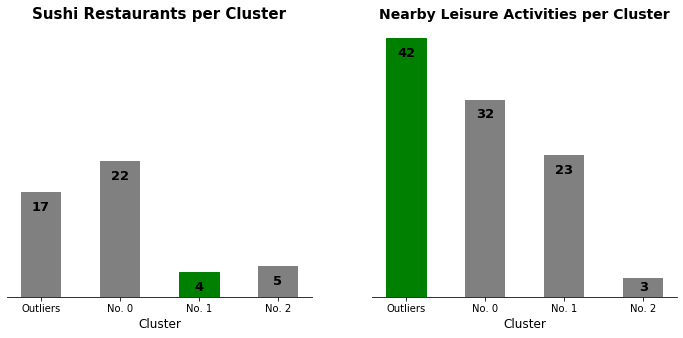

In [145]:
labels_unique =np.unique(labels, return_counts=True)
graph_labels = np.unique(labels)[1:].tolist()
graph_labels =["No. {}".format(k) for k in graph_labels]
graph_labels.insert(0,"Outliers")

fig = plt.figure(figsize=(12,5))
sushi_bar = fig.add_subplot(1,2,1)
leisure_bar = fig.add_subplot(1,2,2, sharex = sushi_bar, sharey = sushi_bar)

bars1 = sushi_bar.bar(labels_unique[0], labels_unique[1], width = 0.5, color = "grey")
sushi_bar.set_xticks(np.unique(labels))
sushi_bar.set_xticklabels(graph_labels)
sushi_bar.tick_params(axis = "y",
                     labelleft = None,
                     left = None)

sushi_bar.set_title("Sushi Restaurants per Cluster", fontsize=15,fontweight="bold")
sushi_bar.set_xlabel("Cluster", fontsize=12)
bars1[np.argmin(labels_unique[1])].set_color("green")

for bar in bars1:
    sushi_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height()-3,
                  int(bar.get_height()), ha="center", color="black", fontsize=13, fontweight="bold")


bars2 = leisure_bar.bar(label_counter.keys(), label_counter.values(), width = 0.5, color ="grey")
leisure_bar.tick_params(axis = "y",
                     labelleft = None,
                     left = None)

leisure_bar.set_title("Nearby Leisure Activities per Cluster", fontsize=14, fontweight="bold")
leisure_bar.set_xlabel("Cluster", fontsize=12)
bars2[np.argmax(label_counter.values())].set_color("green")

for bar in bars2:
    if bar.get_height() > 3:
        height = bar.get_height()-3
    else:
        height = bar.get_height()-2
    leisure_bar.text(bar.get_x() + bar.get_width()/2, height,
                  int(bar.get_height()), ha="center", color="black", fontsize=13, fontweight="bold")

for ax in fig.get_axes():
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.show()

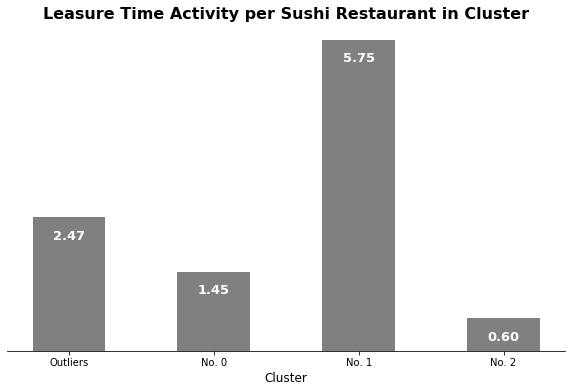

In [164]:
attractivity_score = [attractions/restaurants for restaurants, attractions in zip(list(labels_unique[1]), list(label_counter.values()))]

plt.figure(figsize=(10,6))
bars3 = plt.bar(label_counter.keys(), attractivity_score, width = 0.5, color = "grey")

plt.xticks(np.unique(labels), graph_labels)
plt.tick_params(axis = "y",
                labelleft = None,
                left = None)

for bar in bars3:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.4,
                  "{:.2f}".format(float(bar.get_height())), ha="center", color="w", fontsize=13, fontweight="bold")

    
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title("Leasure Time Activity per Sushi Restaurant in Cluster", fontsize=16, fontweight="bold")
plt.xlabel("Cluster", fontsize=12)

plt.show();



In [14]:
map_result = folium.Map(location=[latitude, longitude], zoom_start=13)


# set color scheme for the clusters
x = np.arange(label_num)
ys = [i + x + (i*x)**2 for i in range(label_num)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map

for lat, lon, poi, cluster in zip(main_data['location.lat'], main_data['location.lng'], main_data['name'], labels):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster != -1:
        c = rainbow[cluster-1]
    else:
        c = "black"
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7).add_to(map_result)
       
map_result

Cluster 0 clearly is cologne city. It is attracting many people from nearby, but also seems to be very contested. This doesn't seem like a good spot for a new restaurant.

It looks like cluster 1 and cluster 2 are spots, which aren't too competitive. However, cluster 2 likely won't attract as many customers from nearby leasure spots.
Let's still have closer look at the possible future competitors in both clusters.